
### **Density-Based Clustering**

In contrast to centroid-based methods like k-means or hierarchical methods like HAC, density-based clustering methods work by identifying "dense" regions of data points separated by regions that are relatively empty. Points in sparse regions are typically treated as noise or border points.

### **DBScan (Density-Based Spatial Clustering of Applications with Noise)**

**Main Idea:** Group together data points that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points. It also marks as outliers the points that are in low-density regions.

**Key Parameters:**
- `eps`: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
- `min_samples`: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

**How Does DBScan Work?**
1. **Core Point:** A point is a core point if at least `min_samples` points are within distance `eps` of it (including the point itself).
2. **Border Point:** A point is a border point if it's within `eps` distance of a core point but has fewer than `min_samples` within its `eps` neighborhood.
3. **Noise or Outlier:** A point that's neither a core nor a border point.

The algorithm starts with an arbitrary point and retrieves all points in its `eps` neighborhood. If the point is a core point, a cluster is formed. If it's a border point, no points are density-reachable from it, and the algorithm visits the next point. This continues until all points are processed.

**Advantages:**
- Can find arbitrarily shaped clusters.
- Doesn't require specifying the number of clusters.
- Can mark outliers.

**Limitations:**
- Struggles with clusters of varying densities.
- Not well-suited for high-dimensional data.


/Users/jeintron/Dropbox/@TEACHING/2023/FALL23/DEV/ist407-707.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


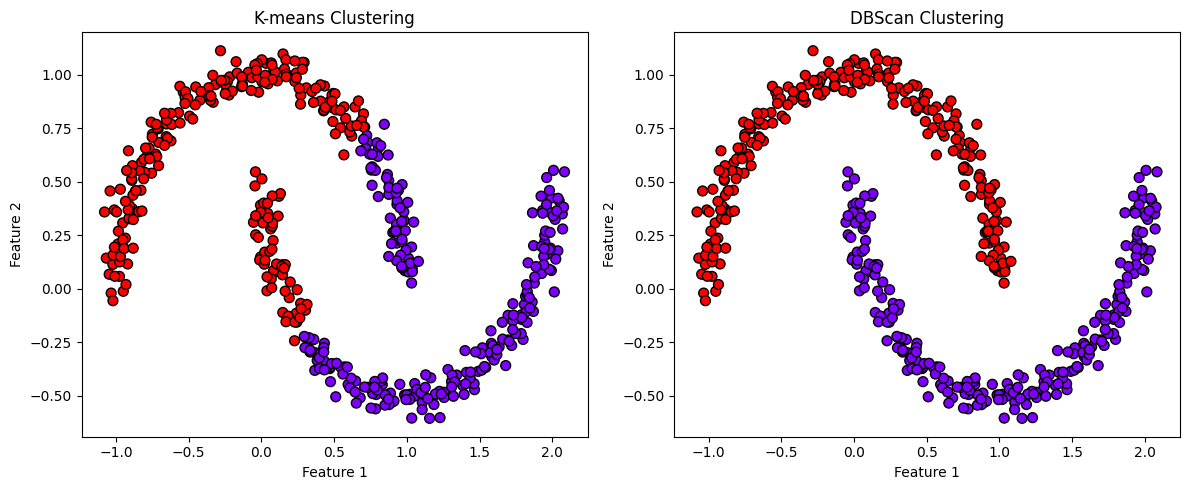

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN

# Generate the make_moons dataset
X, y = make_moons(n_samples=500, noise=0.05, random_state=42)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2)
kmeans_clusters = kmeans.fit_predict(X)

# Apply DBScan clustering
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_clusters = dbscan.fit_predict(X)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=kmeans_clusters, cmap="rainbow", edgecolor="k", s=50)
plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=dbscan_clusters, cmap="rainbow", edgecolor="k", s=50)
plt.title("DBScan Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()



### **HDBScan (Hierarchical Density-Based Spatial Clustering of Applications with Noise)**

**Main Idea:** HDBScan is an extension of DBScan that can detect clusters of varying densities. It works by transforming the space according to the density/sparsity, then applying hierarchical clustering.

**How Does HDBScan Work?**
1. **Transform the space so that the distance between points represents density.**  For each pair of points, the **mutual reachability distance** is defined as the maximum of three values: the actual distance between the two points, the core distance of the first point, and the core distance of the second point. The core distance of a point is the distance from the point to its `min_samples`-th nearest neighbor.

In [ ]:
!pip install hdbscan

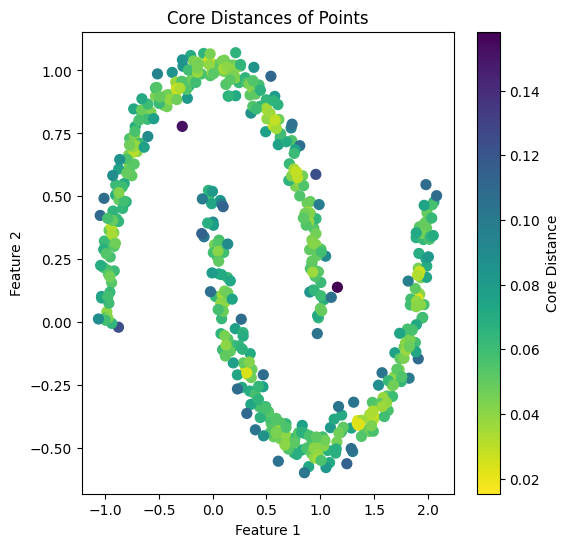

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import NearestNeighbors

# Generate synthetic data
data, _ = make_moons(n_samples=500, noise=0.05)

# Calculate core distances using NearestNeighbors
min_samples = 5  # This should be consistent with the min_samples value you use for HDBScan
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
nearest_neighbors.fit(data)
distances, _ = nearest_neighbors.kneighbors(data)
core_distances = distances[:, -1]  # Get the distance to the min_samples-th nearest neighbor

# Plot data colored by core distance
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], c=core_distances, cmap='viridis_r', s=50)
plt.colorbar(label='Core Distance')
plt.title('Core Distances of Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()





2. **Build the minimum spanning tree of the distance-weighted graph.** Each point is a node, and the edge weights are the mutual reachability distances. The minimum spanning tree (MST) connects all points in such a way that the sum of the edge weights is minimized. The MST ensures that denser regions are connected first, leaving sparser regions to be connected later (potentially as noise).



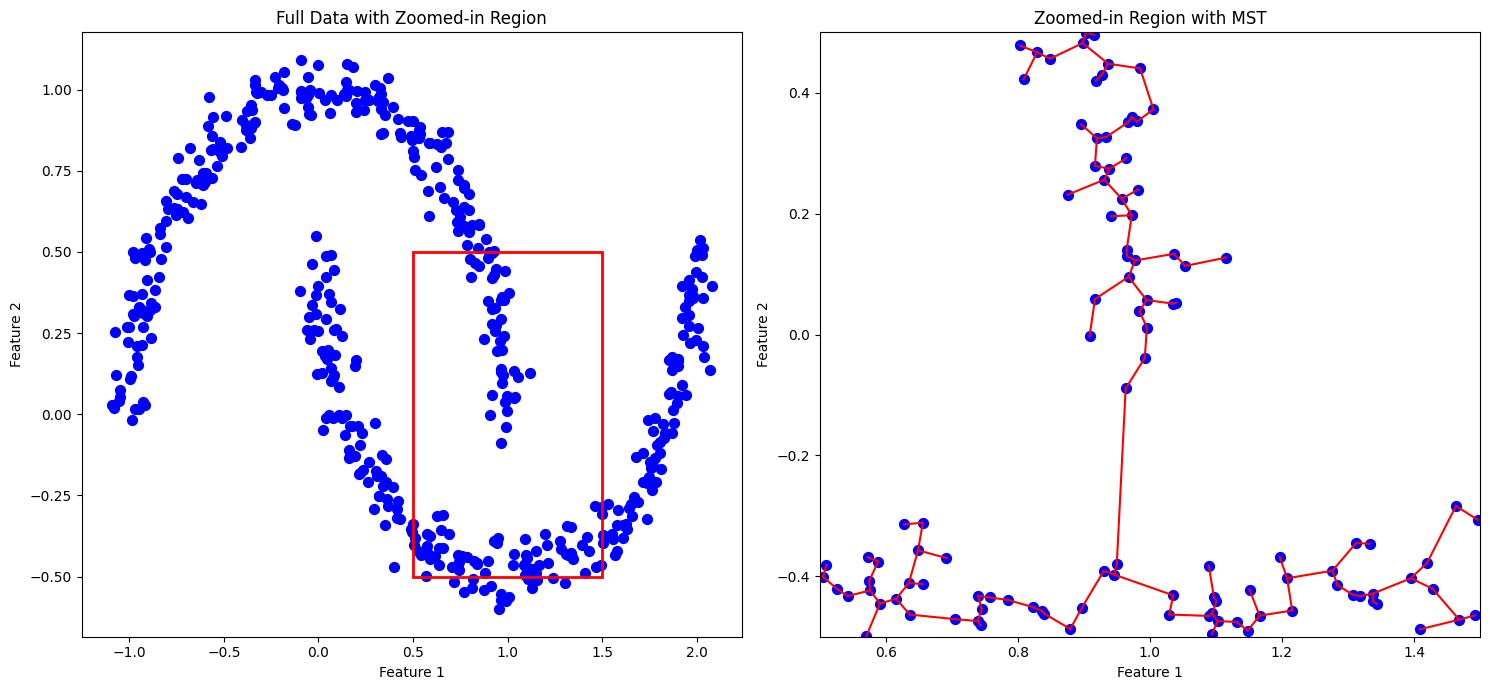

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree

# Generate synthetic data
data, _ = make_moons(n_samples=500, noise=0.05)

# Define the zoomed-in region
x_min, x_max, y_min, y_max = 0.5, 1.5, -0.5, 0.5
filtered_data = data[(data[:, 0] > x_min) & (data[:, 0] < x_max) & (data[:, 1] > y_min) & (data[:, 1] < y_max)]

# Compute the MST for the filtered data
distance_matrix = squareform(pdist(filtered_data))
mst = minimum_spanning_tree(distance_matrix).toarray()

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Left plot: Full data with zoomed-in box
ax1.scatter(data[:, 0], data[:, 1], c='blue', s=50)
ax1.set_title('Full Data with Zoomed-in Region')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
rectangle = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='red', linewidth=2)
ax1.add_patch(rectangle)

# Right plot: Zoomed-in data with MST
ax2.scatter(filtered_data[:, 0], filtered_data[:, 1], c='blue', s=50)
for i in range(mst.shape[0]):
    for j in range(mst.shape[1]):
        if mst[i, j] != 0:
            ax2.plot([filtered_data[i, 0], filtered_data[j, 0]], [filtered_data[i, 1], filtered_data[j, 1]], 'r-')
ax2.set_xlim([x_min, x_max])
ax2.set_ylim([y_min, y_max])
ax2.set_title('Zoomed-in Region with MST')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()



3. **Construct a hierarchy of connected components.** As you increase a distance threshold from the minimum to the maximum mutual reachability distance, edges in the MST longer than this threshold are removed. This process results in the splitting of the MST into multiple connected components (clusters). Tracking these splits as the threshold increases gives a hierarchy of connected components.
4. **Condense the tree, then extract the stable clusters.**
   - **Condensing the Tree**: The hierarchical tree from the previous step can be vast and intricate. To simplify, a condensed tree is constructed where only the most "prominent" clusters (that persist over a range of thresholds) are retained.
   - **Extracting Clusters**: From the condensed tree, stable clusters are extracted based on their persistence (i.e., the range of thresholds over which they exist). A cluster that persists over a large range is considered stable and is less likely to be just noise or an artifact of the data.

Visualizing the final step can be a condensed tree diagram, followed by a plot of the data points colored based on their cluster assignments.

**Key Parameters:**
- `min_cluster_size`: The minimum size of clusters; smaller clusters are treated as noise.
- `min_samples`: Similar to DBScan, used for the soft clustering part of HDBScan, where points may be assigned to multiple clusters (akin to a fuzziness parameter).

**Advantages:**
- Can find clusters of varying densities.
- Doesn't require specifying the number of clusters.
- More flexible than DBScan.

**Limitations:**
- More complex and computationally intensive than DBScan.
- Still can struggle in very high-dimensional spaces.

### Exercise

In the following example, use the parameters for DBScan and HDBScan to optimize the fit for data.  Can you find parameter setting that result in approximately the same clustering?  How would you do this without visual inspection?

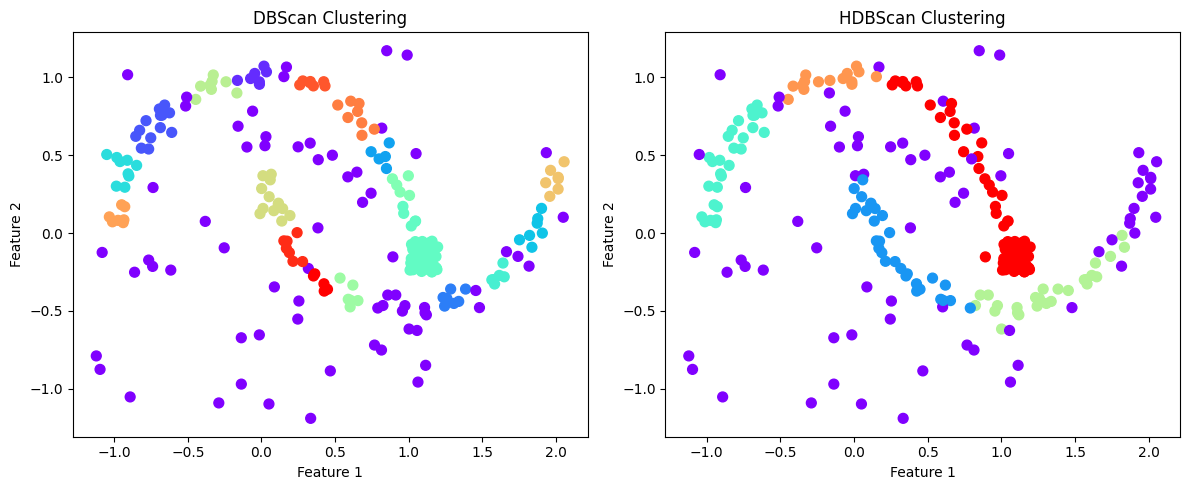

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import hdbscan
from sklearn.cluster import DBSCAN

# Create synthetic data: two moons + noise + a dense small cluster
moons_data, _ = make_moons(n_samples=150, noise=0.05)
noise = np.random.rand(50, 2) * 2.5 - 1.25
dense_cluster = np.random.rand(50, 2) * 0.2 + [1, -0.25]
data = np.vstack([moons_data, noise, dense_cluster])

# DBScan clustering
dbscan_labels = DBSCAN(eps=0.11, min_samples=5).fit_predict(data)

# HDBScan clustering
hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10).fit_predict(data)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(data[:, 0], data[:, 1], c=dbscan_labels, cmap='rainbow', s=50)
ax1.set_title('DBScan Clustering')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')

ax2.scatter(data[:, 0], data[:, 1], c=hdbscan_labels, cmap='rainbow', s=50)
ax2.set_title('HDBScan Clustering')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()
